# GANs

In the realm of machine learning, the ability to construct extensive image datasets and access unprecedented computational resources has facilitated the rise of deep learning techniques, notably revolutionizing the landscape of image generation. Specifically, Ian Goodfellow and his colleagues introduced Generative Adversarial Networks (GANs) in 2014, which have since emerged as a fundamental cornerstone in the field of computer vision.

At their core, GANs are composed of two neural networks – a generator and a discriminator – engaged in a dynamic adversarial training process. The generator strives to create synthetic data that is indistinguishable from real data, while the discriminator aims to accurately classify whether the given data is real or generated (see image below). 

<img src="figures/gans.png" style="height: 500px;"/>

[source](https://www.analyticsvidhya.com/blog/2021/04/lets-talk-about-gans/)

The main idea is that the generator tries to fool the discriminator by showing it fake training data samples and the discriminator tries to be as clever as possible. To do so, it learns the probability distribution of our training data. Training aims to improve both of those neural nets that have competitive objective, hence the term *adversarial*.

The discriminator is a simple binary classifier, so it's loss is a simple binary cross-entropy.
By writing:
- $z$ the input noise
- $x$ a training sample
- $G(z)$ the image outputted by the generator
- $D(x)$ the probability of the image being real outputted by the discriminator

We get the loss, that will have to be maximized when training the discriminator :
$$
log(D(x)) + log(1-D(G(z)))
$$
Yet, the generator objective is to fool the discriminator: it tries to minimize $log(1-D(G(z)))$
This way, we get the adversarial objectif, encompassing adversarial training of our generator and discriminator:
$$
\operatorname*{min}_{G}\operatorname*{max}_{D}V(D,G)=\mathbb{E}_{x\sim p_{\mathrm{data}}}[\log D(x)]+\mathbb{E}_{z\sim p_{z}}[\log(1-D(G(z)))].
$$
In practice, we first train the discriminator by ascending gradient and train the generator every k-steps by descending gradient. Moreover, this training of the generator in actually rather done by maximizing $log(D(G(z)))$, providing better gradients in early training when  $log(1 - D(G(z)))$ saturates because of poor quality of $G(z)$.

# SinGAN

## Principle

GAN models, as described above, typically require a large amount of training data to perform well. In 2019, Tamar Rott Shaham et al proposed SinGAN: Learning a Generative Model from a Single Natural Image, where they harnessed the generative capabilities of GAN architecture to generate samples from a single-image dataset.

To achieve this, they employed a multi-scale architecture, specifically a pyramid of generators. Each generator was adversarially trained against a downsampled version of the training image, progressively increasing in scale. All the generators and discriminators share the same receptive field. Consequently, as the size of the input increased, the effective size of the associated generator and discriminator's receptive fields decreases as we ascended the pyramid. This approach allows the generators higher up in the pyramid to capture finer details. The process is illustrated in the image below.

<img src="figures/singan.png" style="height: 500px;"/>

[source](https://arxiv.org/pdf/1905.01164.pdf)

## Training

Training is conducted using the classical adversarial loss described above, augmented by a reconstruction term. 

$$
\operatorname*{min}_{G_n}\operatorname*{max}_{D_n}L_{adv}+\alpha L_{rec}(G_n)
$$

$L_{adv}$ represents the WGAN-GP loss, introduced in [a 2017 paper](https://arxiv.org/pdf/1704.00028.pdf). This loss, though slightly different from the adversarial loss described earlier, is equivalent and is designed to enhance training stability.

$L_{rec}$ represents a simple square Euclidean distance calculated between two entities:
- The generated patch at the lower scale ($n=N$) and the corresponding patch from the training sample.
- The generated image solely from the previously generated image of the preceding scale (without noise) for other scales.
This additional term ensures that a noise map alone, in the conventional GANs generation manner, will effectively produce the corresponding training sample.

Training is executed sequentially. Initially, the generator and discriminator for scale $n=N$ are trained. Subsequently, the generator and discriminator for the next scale are trained with the previous ones frozen, and this process continues iteratively.

In [1]:
# load github repo
try:
    !rm -r ./SinGAN
except:
    pass
get_ipython().system(f"git clone https://github.com/eustlb/SinGAN.git")

rm: ./SinGAN: No such file or directory
Clonage dans 'SinGAN'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 55 (delta 9), reused 52 (delta 6), pack-reused 0
Réception d'objets: 100% (55/55), 4.53 Mio | 24.57 Mio/s, fait.
Résolution des deltas: 100% (9/9), fait.


# Pre-training

One limitation of such an approach is that the model must be re-trained from scratch each time. However, when working with images that share common characteristics, such as skylines of the same city, one might question whether re-training from scratch is truly necessary or if we could benefit from previous training, specifically through transfer learning.

In this section, we aim to test this hypothesis. The experimental protocol is as follows:
1. Train the model on the first image.
2. Train the model on the second image.
3. Retrain the model on the second image, starting from the generator weights of the first image's training for each scale, and do the same for the discriminator.
4. Compare the loss curves.

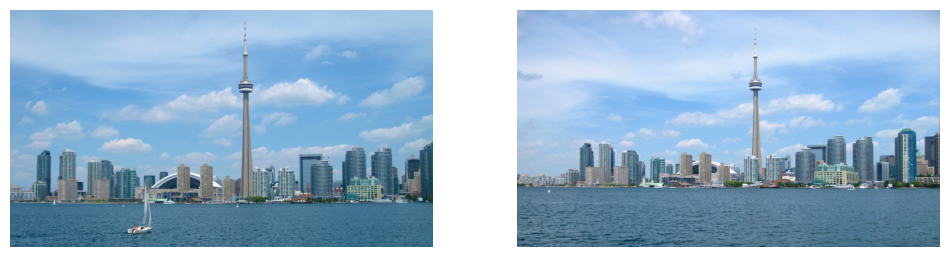

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img1_path = "test-images/img1.jpg"
img2_path = "test-images/img2.jpg"

img1 = Image.open(img1_path)
img2 = Image.open(img2_path)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.array(img1))

plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np.array(img2))
plt.axis('off')
plt.show()

In [5]:
def resize_img(pil_img, new_width):
    """
    Resizes keeping aspect ratio.
    """
    original_width, original_height = pil_img.size
    aspect_ratio = original_width / original_height
    new_height = int(new_width / aspect_ratio)

    resized_image = pil_img.resize((new_width, new_height))

    return resized_image

img1 = resize_img(img1, 250)
img2 = resize_img(img2, 250)

print(f"img1 size: {img1.size}")
print(f"img2 size: {img2.size}")

# save images for training 
r_img1_path = "test-images/img1_resized.png"
r_img2_path = "test-images/img2_resized.png"

img1.save(r_img1_path)
img2.save(r_img2_path)

img1 size: (250, 140)
img2 size: (250, 140)


In [ ]:
# training on first image:
!python3 /kaggle/working/singan_iin/SinGAN/generation/main.py --root ./img1.png --results-dir results-img1

Namespace(device='cuda', device_ids=[0], gen_model='g_multivanilla', dis_model='d_vanilla', min_features=32, max_features=32, num_blocks=5, kernel_size=3, padding=0, root='/kaggle/working/img1.png', min_size=25, max_size=250, scale_factor_init=0.75, noise_weight=0.1, batch_size=1, crop_size=0, num_steps=4000, lr=0.0005, gen_betas=[0.5, 0.9], dis_betas=[0.5, 0.9], num_critic=1, step_size=2000, gamma=0.1, penalty_weight=0.1, reconstruction_weight=10.0, adversarial_weight=1.0, seed=11501, print_every=200, eval_every=100, results_dir='results_img1', save='2024-01-16_18-44-18', evaluation=False, model_to_load='', models_to_load='', amps_to_load='', use_tb=False, save_path='results_img1/2024-01-16_18-44-18')
MultiVanilla(
  (curr): Vanilla(
    (features): Sequential(
      (0): BasicBlock(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (lrelu): LeakyReLU(negative_s

In [ ]:
# training on second image:
!python3 /kaggle/working/singan_iin/SinGAN/generation/main.py --root ./img2.png --results-dir results-img2

Namespace(device='cuda', device_ids=[0], gen_model='g_multivanilla', dis_model='d_vanilla', min_features=32, max_features=32, num_blocks=5, kernel_size=3, padding=0, root='./img2.png', min_size=25, max_size=250, scale_factor_init=0.75, noise_weight=0.1, batch_size=1, crop_size=0, num_steps=4000, lr=0.0005, gen_betas=[0.5, 0.9], dis_betas=[0.5, 0.9], num_critic=1, step_size=2000, gamma=0.1, penalty_weight=0.1, reconstruction_weight=10.0, adversarial_weight=1.0, seed=10064, print_every=200, eval_every=100, results_dir='results_img2', save='2024-01-16_19-10-39', evaluation=False, model_to_load='', models_to_load='', amps_to_load='', use_tb=False, save_path='results_img2/2024-01-16_19-10-39')
MultiVanilla(
  (curr): Vanilla(
    (features): Sequential(
      (0): BasicBlock(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (lrelu): LeakyReLU(negative_slope=0.2, inpl

In [ ]:
import glob
import os
import shutil

# prepare weights to be later loaded

img1_results_dir = "results_img1"
params_dir = "params"

if not os.path.exists(params_dir):
    # Create the directory if it doesn't exist
    os.makedirs(params_dir)

for params_path_g in glob.glob(os.path.join(img1_results_dir, "*/s*/g_multivanilla*.pt")):
    scale = params_path_g.split('/')[-2][-1]
    saving_path_g = os.path.join(params_dir, f"{scale}.pt")
    shutil.copy(params_path_g, saving_path_g)

    params_path_d = params_path_g.replace("g_multivanilla", "d_vanilla")
    saving_path_d = os.path.join(params_dir, f"{scale}_d.pt")
    shutil.copy(params_path_d, saving_path_d)

In [ ]:
# training img2 with img1 generator weights initialisation:
!python3 /kaggle/working/singan_iin/SinGAN/generation/main.py --root ./img2.png --results-dir results-pretrained --models-to-load params

Namespace(device='cuda', device_ids=[0], gen_model='g_multivanilla', dis_model='d_vanilla', min_features=32, max_features=32, num_blocks=5, kernel_size=3, padding=0, root='./img2.png', min_size=25, max_size=250, scale_factor_init=0.75, noise_weight=0.1, batch_size=1, crop_size=0, num_steps=4000, lr=0.0005, gen_betas=[0.5, 0.9], dis_betas=[0.5, 0.9], num_critic=1, step_size=2000, gamma=0.1, penalty_weight=0.1, reconstruction_weight=10.0, adversarial_weight=1.0, seed=2477, print_every=200, eval_every=100, results_dir='results_pretrained', save='2024-01-16_21-46-26', evaluation=False, model_to_load='', models_to_load='./singan_iin/params', amps_to_load='', use_tb=False, save_path='results_pretrained/2024-01-16_21-46-26')


Loading models... scale 1
generator loaded !
discriminator loaded !
MultiVanilla(
  (curr): Vanilla(
    (features): Sequential(
      (0): BasicBlock(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
        (batch_norm): BatchNorm2d(32, eps=1e-05, mome

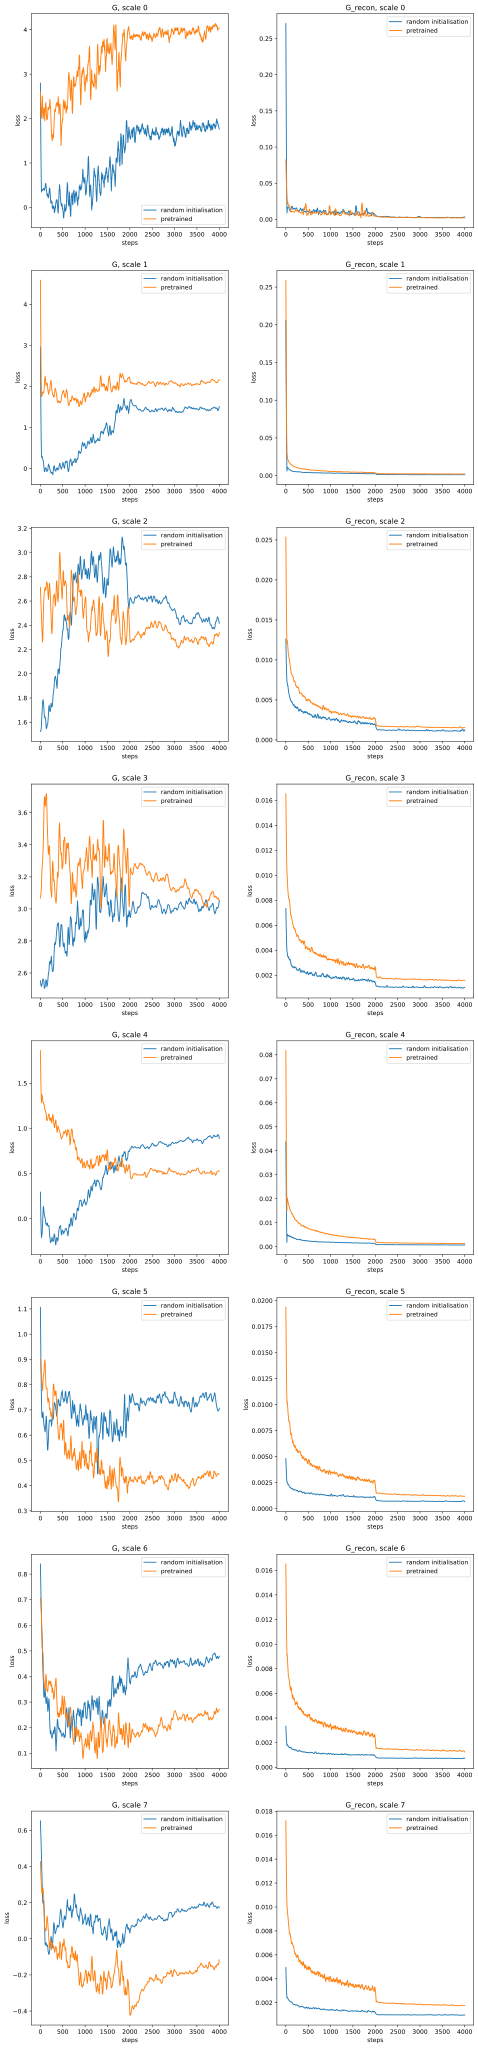

In [33]:
import pickle
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')


# Savitzky-Golay filter for smoothing
window_size = 50  
order = 2   

fig, axs = plt.subplots(8, 2, figsize=(12, 6*8))
fig.tight_layout(pad=5.0)

for scale in range(8):

    with open(f"training-results/results-img2/losses_{scale}.pkl", 'rb') as file:
        losses_dict1 = pickle.load(file)

    with open(f"training-results/results-img2-pretrained/losses_{scale}.pkl", 'rb') as file:
        losses_dict2 = pickle.load(file)

    for i, key in enumerate(['G', 'G_recon']):
        y_smooth_1 = savgol_filter(losses_dict1[key], window_size, order)
        y_smooth_2 = savgol_filter(losses_dict2[key], window_size, order)
        # axs[row_idx, col_idx].plot(losses_dict[key])
        # axs[row_idx, col_idx].plot(y_smooth_1, label="random initialisation")
        # axs[row_idx, col_idx].plot(y_smooth_2, label="pretrained")
        # axs[row_idx, col_idx].legend()
        # axs[row_idx, col_idx].set_title(f'{key}')
        # axs[row_idx, col_idx].set_xlabel('steps')

        axs[scale, i].plot(y_smooth_1, label="random initialisation")
        axs[scale, i].plot(y_smooth_2, label="pretrained")
        axs[scale, i].legend()
        axs[scale, i].set_title(f'{key}, scale {scale}')
        axs[scale, i].set_xlabel('steps')
        axs[scale, i].set_ylabel('loss')


**Comments**

Interestingly, pretraining appears to confer benefits primarily to the last scale. This observation leads us to hypothesize that similarities between the two images are more prominently situated at finer scales. This could elucidate why pretrained weights for generation prove to be most effective for such scales.